# Google - American Sign Language Fingerspelling Recognition with TensorFlow



這本筆記本大部份取材自 [Guthema 與 elliot robot](https://www.kaggle.com/code/gusthema/asl-fingerspelling-recognition-w-tensorflow)。

「Google - 美國手語手指拼字辨識」是 2023 年的 Kaggle 競賽。該次競賽的目標是預測一組視訊影格中的美國手語手指拼寫 (ASL Fingerspelling) 並將其翻譯為文字（短語，phrase）。

[Guthema 與 elliot robot](https://www.kaggle.com/code/gusthema/asl-fingerspelling-recognition-w-tensorflow) 使用 TensorFlow 訓練 Transformer 模型，獲得金牌獎。

# 1\. 準備
## 1.1 安裝 MediaPipe

特別是對於本次比賽，您將需要 MediaPipe 函式庫來處理資料並將其視覺化

In [1]:
!pip install --quiet mediapipe 
# 如果過程中出現大量套件不相容的 ERROR 訊息，暫時先不用理會。

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires protobuf<4.0.0dev,>=3.12.0, but y

## 1.2 載入套件

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe as mp

import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc, rcParams

In [45]:
ROOT = '/kaggle/input/asl-fingerspelling'

CHAR_TO_NUM = os.path.join(ROOT, 'character_to_prediction_index.json')
TRAIN_META = os.path.join(ROOT, 'train.csv')
TRAIN_DIR = os.path.join(ROOT, 'train_landmarks')
SUPPL_DIR = os.path.join(ROOT, 'supplemental_landmarks')

PREPROC_DIR = '/kaggle/working/preprocessed'

# 2\. 資料集探索
## 2.1 載入訓練資料集目錄 `train.csv`

- 使用 [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) 載入訓練資料集目錄 `train.csv`
- 使用 [`pandas.DataFrame.shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) 印出形狀，可知這份目錄由 5 個欄位（colums）和 67208 個索引（indices）組成。

In [5]:
metadata_df = pd.read_csv(TRAIN_META)
print("整組訓練資料集的形狀是 {}".format(metadata_df.shape))

整組訓練資料集的形狀是 (67208, 5)


- 使用 [`pandas.DataFrame.head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) 印出前 5 列，

In [6]:
metadata_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [7]:
class SequenceSample():
    def __init__(self, sample_index):
        sequence_df = metadata_df.iloc[sample_index]
        self.name = f'Sequence {sample_index:04d}'
        self.sequence_id = sequence_df['sequence_id']
        self.file_id = sequence_df['file_id']
        self.phrase = sequence_df['phrase']

    def get_path(self):
        return os.path.join(TRAIN_DIR, f'{self.file_id}.parquet')

    def get_df(self):
        # 獲取 Parquet 檔案的路徑
        pq_source = self.get_path()
        
        # 設置過濾條件，以過濾出對應 sequence_id 的數據
        pq_filter = [[('sequence_id', '=', self.sequence_id)],]
        
        # 讀取並過濾 Parquet 檔案，返回 Pandas DataFrame
        pq_table = pq.read_table(pq_source, filters = pq_filter)
        return pq_table.to_pandas()

# 創建索引為0的序列樣本
sample_sequence = SequenceSample(0)

# 查看序列樣本的屬性
sample_sequence.__dict__

{'name': 'Sequence 0000',
 'sequence_id': 1816796431,
 'file_id': 5414471,
 'phrase': '3 creekhouse'}

## 2.2 取出一筆序列資料

**`train.csv`** 中的每一個資料列都有一個 `phrase` 欄位和它的 `sequence_id`、`path`、`file_id` 等欄位。
- `file_id` 是 landmarks 資料所在的路徑，
- `sequence_id` 是 landmarks 資料檔案內 landmark 序列的唯一索引。

下圖是一個範例，顯示文件如何連接。

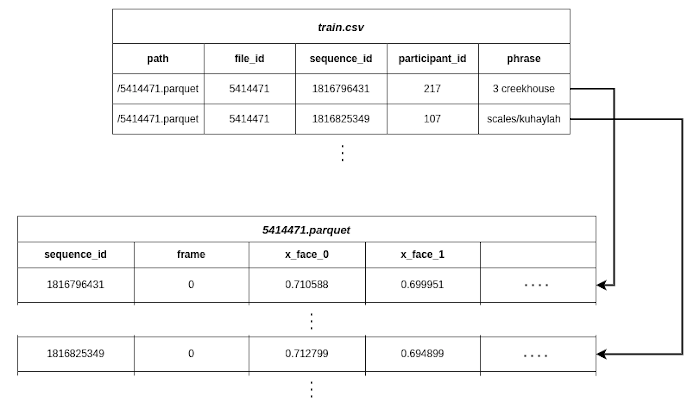

使用 [`pandas.DataFrame.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) 取出「`train.csv`」第一個資料列的 landmark 檔案，作為示範。

現在，我們打開 parquet 檔案並獲取特定 `sequence_id` 的資料。
- 使用 [`pyarrow.parquet.read_table`](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html) 將 parquet 檔案轉換成表格（pyarrow.Table）。
- 使用 [`pyarrow.Table.to_pandas`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas) 將表格轉換成 pandas.DataFrame。
- 使用 [`pandas.DataFrame.head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) 印出前 5 列。

In [8]:
sample_sequence_df = sample_sequence.get_df()
print(sample_sequence_df.shape)
sample_sequence_df.head()

(123, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


由此可知，「***3 creekhouse***」這個詞組包含 
- 123 列，也就是有 123 個影格（frame）
- 1630 欄，包含序列編號（`sequence_id`）、影格編號（`frame`），以及每張影格的 1628 個 landmark 座標。

## 2.3 使用 MediaPipe API 進行資料視覺化

- 選擇詞組「***3 Creek house***」的手部 landmark 數據。
- 使用 [MediaPipe](https://developers.google.com/mediapipe) 的 [hand landmarker API](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker) 命令來對這筆資料進行視覺化。
- 在 MediaPipe 中，一隻手有 21 個關鍵點（如下圖）。
- 參考：[Data visualization using mediapipe APIs by sknadig](https://www.kaggle.com/code/nadigshreekanth/data-visualization-using-mediapipe-apis)

![hand-landmarks.png](https://ai.google.dev/static/mediapipe/images/solutions/hand-landmarks.png)
圖源: https://developers.google.com/mediapipe/solutions/vision/hand_landmarker

In [9]:
# 使用 MediaPipe 函式庫提取雙手的 landmark 資料

def extract_landmarks(keypoint: pd.Series, part: str) -> tuple:
    
    # 載入 MediaPipe 的姿勢和手部偵測模型以及繪圖工具
    mp_pose = mp.solutions.pose
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils 
    mp_styles = mp.solutions.drawing_styles
    default_style = mp_styles.get_default_hand_landmarks_style()
    
    # 取得對應部位的 x, y, z 座標
    xs = keypoint.filter(regex=f"x_{part}.*").values
    ys = keypoint.filter(regex=f"y_{part}.*").values
    zs = keypoint.filter(regex=f"z_{part}.*").values

     # 初始化空白圖像和 landmark 列表
    image = np.zeros((600, 600, 3))
    landmarks = landmark_pb2.NormalizedLandmarkList()

    # 加入 landmark 資料
    for x, y, z in zip(xs, ys, zs):
        landmarks.landmark.add(x=x, y=y, z=z)

    # 繪製 landmark 到圖像上
    mp_drawing.draw_landmarks(
            image,
            landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec = default_style)

    return image, landmarks

def get_both_hands(seq_df: pd.DataFrame) -> tuple:
    images = []
    landmarks = []
    
    # 遍歷序列中的每一列資料
    for seq_idx in range(len(seq_df)):
        keypoints = seq_df.iloc[seq_idx]
        
        # 提取右手和左手的 landmark 資料
        results_R = extract_landmarks(keypoints, 'right_hand')
        results_L = extract_landmarks(keypoints, 'left_hand')
        
        # 儲存圖像和 landmark 資料
        images.append([results_R[0].astype(np.uint8), 
                       results_L[0].astype(np.uint8)])

        landmarks.append([results_R[1], results_L[1]])

    return images, landmarks

使用 [Matplotlib](https://matplotlib.org/) ，由圖片集創建動畫。

參考
- [`matplotlib.rcParams`](https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams) 
- [`matplotlib.animation.FuncAnimation`](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)
- [Embedding Matplotlib Animations in Python (google colab notebook)](https://stackoverflow.com/questions/61103994/embedding-matplotlib-animations-in-python-google-colab-notebook)

In [10]:
# 設定動畫嵌入的大小限制為 2^128
rcParams['animation.embed_limit'] = 2**128

# 設定保存圖像時的填充寬度為 0
rcParams['savefig.pad_inches'] = 0

# 設定動畫的 HTML 格式為 'jshtml'
rc('animation', html='jshtml')

def create_animation(images):
    # 創建一個 6x9 英寸的圖像
    fig = plt.figure(figsize=(6, 9))
    
    # 添加 Axes 物件，填滿整個圖像區域
    # 但不顯示 x 軸、y 軸
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # 顯示第一張圖片，使用灰度色圖
    im = ax.imshow(images[0], cmap="gray")
    
    # 關閉圖像顯示，以便動畫在背景中運行
    plt.close(fig)

    # 動畫函數，根據目前的影格索引更新圖像。
    def animate_func(frame_idx: int):
        im.set_array(images[frame_idx])
        return [im]
    
    # 創建動畫，間隔為每秒 10 影格 (1000 ms / 10)
    anim = animation.FuncAnimation(
        fig, 
        animate_func, 
        frames=len(images), 
        interval=1000/10
    )

    return anim

In [11]:
# 處理 sample_sequence_df，取得雙手圖檔
hand_images, hand_landmarks = get_both_hands(sample_sequence_df)

# 顯示右手動畫
create_animation(np.array(hand_images)[:, 0])

# 3\. 資料預處理

為了方便和效率起見，我們將重組數據，使得每個 parquet 檔案包含 landmarks 數據及其代表的詞組。這樣我們就不必在 `train.csv` 及它的 parquet 檔案之間切換。

我們將以 [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) 格式儲存新資料。TFRecord 格式是一種簡單格式，專門用來儲存二進位記錄序列。使用 TFRecord 儲存和載入資料更加高效和快速。

參考：
- https://www.kaggle.com/code/irohith/aslfr-preprocess-dataset
- https://www.kaggle.com/code/shlomoron/aslfr-parquets-to-tfrecords-cleaned

ASL-Fingerspelling 主要關注手部動作。因此，我們將採用手部的 landmark 座標和 pose landmark 座標來訓練模型。

## 3.1 取得與手部運動相關的 pose landmark 座標。

這張圖說明了與手部運動相關的 pose landmark。
pose landmark 也來自 parquet 檔案。


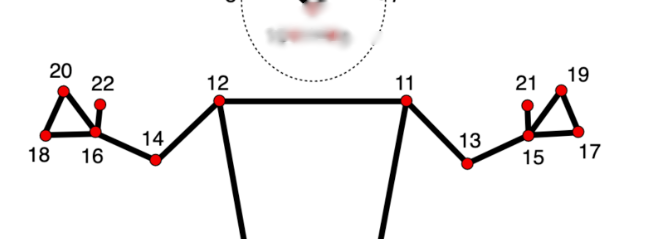

[Image source](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker)

## 3.2 提取關鍵點座標的標籤與索引值

In [12]:
# 手部運動的姿勢座標
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

def get_labels_of(ax):
    labels = (
        [f'{ax}_right_hand_{i}' for i in range(21)] +
        [f'{ax}_left_hand_{i}' for i in range(21)] +
        [f'{ax}_pose_{i}' for i in POSE]
    )
    return labels

# x, y, z 軸的標籤
X_LABELS = get_labels_of('x')
Y_LABELS = get_labels_of('y')
Z_LABELS = get_labels_of('z')

# 所有軸的標籤，也就是待訓練的特徵
FEATURES = X_LABELS + Y_LABELS + Z_LABELS

for feat in FEATURES:
    print(f'{feat:20s}', end = '')

x_right_hand_0      x_right_hand_1      x_right_hand_2      x_right_hand_3      x_right_hand_4      x_right_hand_5      x_right_hand_6      x_right_hand_7      x_right_hand_8      x_right_hand_9      x_right_hand_10     x_right_hand_11     x_right_hand_12     x_right_hand_13     x_right_hand_14     x_right_hand_15     x_right_hand_16     x_right_hand_17     x_right_hand_18     x_right_hand_19     x_right_hand_20     x_left_hand_0       x_left_hand_1       x_left_hand_2       x_left_hand_3       x_left_hand_4       x_left_hand_5       x_left_hand_6       x_left_hand_7       x_left_hand_8       x_left_hand_9       x_left_hand_10      x_left_hand_11      x_left_hand_12      x_left_hand_13      x_left_hand_14      x_left_hand_15      x_left_hand_16      x_left_hand_17      x_left_hand_18      x_left_hand_19      x_left_hand_20      x_pose_13           x_pose_15           x_pose_17           x_pose_19           x_pose_21           x_pose_14           x_pose_16           x_pose_18           

In [13]:
# 快速查看 list 的頭尾和長度
def glance(li, Nhead=2, Ntail=1):
    head = str(li[:Nhead])[:-1] 
    body = ', ... ,'
    tail = str(li[-Ntail:])[1:]
    length = len(li)
    return f'{head + body + tail}, len = {length}'

# 預覽標籤列表
print('X_LABELS:', glance(X_LABELS))
print('Y_LABELS:', glance(Y_LABELS))
print('Z_LABELS:', glance(Z_LABELS))
print('FEATURES:', glance(FEATURES))

X_LABELS: ['x_right_hand_0', 'x_right_hand_1', ... ,'x_pose_22'], len = 52
Y_LABELS: ['y_right_hand_0', 'y_right_hand_1', ... ,'y_pose_22'], len = 52
Z_LABELS: ['z_right_hand_0', 'z_right_hand_1', ... ,'z_pose_22'], len = 52
FEATURES: ['x_right_hand_0', 'x_right_hand_1', ... ,'z_pose_22'], len = 156


In [14]:
# 從 features 中提取標籤的索引值
def extract_idx_by(pattern, labels=FEATURES, pose=None):   
    if not pose:
        indices = [i for i, col in enumerate(labels) 
                   if pattern in col]
    else:
        indices = [i for i, col in enumerate(labels) 
                   if pattern in col and int(col[-2:]) in pose]
    return indices

X_IDX = extract_idx_by("x_")
Y_IDX = extract_idx_by("y_")
Z_IDX = extract_idx_by("z_")
RHAND_IDX = extract_idx_by("right")
LHAND_IDX = extract_idx_by("left")
RPOSE_IDX = extract_idx_by("pose", pose = RPOSE)
LPOSE_IDX = extract_idx_by("pose", pose = LPOSE)

print('X_IDX:', glance(X_IDX))
print('Y_IDX:', glance(Y_IDX))
print('Z_IDX:', glance(Z_IDX))
print('RHAND_IDX:', glance(RHAND_IDX))
print('LHAND_IDX:', glance(LHAND_IDX))
print('RPOSE_IDX:', glance(RPOSE_IDX))
print('LPOSE_IDX:', glance(LPOSE_IDX))

X_IDX: [0, 1, ... ,51], len = 52
Y_IDX: [52, 53, ... ,103], len = 52
Z_IDX: [104, 105, ... ,155], len = 52
RHAND_IDX: [0, 1, ... ,124], len = 63
LHAND_IDX: [21, 22, ... ,145], len = 63
RPOSE_IDX: [47, 48, ... ,155], len = 15
LPOSE_IDX: [42, 43, ... ,150], len = 15


## 3.3 預處理資料集並將其寫入 TFRecords

巡訪（iterate）每個 parquet 檔案中的每個序列資料，提取出所有影格的 landmark 資料和對應於序列的詞組（phrase），然後寫入 TFRecords 格式的資料集。

由於資料預處理過程比較繁瑣，故拆解成 4 個部分做分析。
- **§3.3.1 根據單一 `file_id` 從 `parquet` 檔案中取出儲存為 `numpy.ndarray`**
- **§3.3.2 檢查第一層巡訪的對象**
- **§3.3.3 檢查影格中的 NaN 數量**
- **§3.3.4 建立 `tf.train.Example` 並序列化**

熟悉過程者，可以直接閱讀 **§3.3.5 完整執行整組訓練資料集的預處理**

### 3.3.1 根據單一 `file_id` 從 `parquet` 檔案中取出儲存為 `numpy.ndarray`
從 `metadata_df` 取出所有 parquet 檔案不重複的 `file_id`。

In [15]:
file_id_list = metadata_df.file_id.unique()
print(file_id_list)

[   5414471  105143404  128822441  149822653  152029243  169560558
  175396851  234418913  296317215  349393104  388576474  425182931
  433948159  450474571  474255203  495378749  522550314  527708222
  532011803  546816846  566963657  568753759  614661748  638508439
  649779897  654436541  683666742  871280215  882979387  933868835
  939623093 1019715464 1021040628 1098899348 1099408314 1133664520
 1134756332 1255240050 1320204318 1341528257 1358493307 1365275733
 1365772051 1405046009 1448136004 1497621680 1552432300 1557244878
 1562234637 1643479812 1647220008 1662742697 1664666588 1726141437
 1785039512 1865557033 1880177496 1905462118 1906357076 1920330615
 1967755728 1969985709 1997878546 2026717426 2036580525 2072296290
 2072876091 2118949241]


任取一個 `file_id`（例如 1785039512）來測試。

parquet 檔名（`pq_file`）為 `1785039512.parquet`。

選擇 `metadata_df` 中 file_id 等於 1785039512 的資料列，儲存在 `file_df`。



In [16]:
sample_file_id = 1785039512
pq_file = os.path.join(TRAIN_DIR, f'{sample_file_id}.parquet')
file_df = metadata_df.loc[metadata_df['file_id'] == sample_file_id]
file_df

,path,file_id,sequence_id,participant_id,phrase
53228,train_landmarks/1785039512.parquet,1785039512,1622829134,105,2796 west golden willow drive
53229,train_landmarks/1785039512.parquet,1785039512,1622830744,1,973-471-9887
53230,train_landmarks/1785039512.parquet,1785039512,1622838988,196,497-723-6992
53231,train_landmarks/1785039512.parquet,1785039512,1622893124,95,reallyloud.co.uk/simaii
53232,train_landmarks/1785039512.parquet,1785039512,1622894248,68,3938 duskywing
...,...,...,...,...,...
54222,train_landmarks/1785039512.parquet,1785039512,1653958658,176,8272 west ute place
54223,train_landmarks/1785039512.parquet,1785039512,1653973495,4,dpdciechanow/shoufengqinpu
54224,train_landmarks/1785039512.parquet,1785039512,1654009602,216,caduser.photron.co.jp/2773
54225,train_landmarks/1785039512.parquet,1785039512,1654050434,92,439 stanton woods


選擇 `pf_file` 中的 `sequence_id` 欄位及所有特徵（`FEATURES`）欄位，儲存在 `pd_df`。

In [17]:
selected = ['sequence_id'] + FEATURES
pq_df = pq.read_table(pq_file, columns=selected).to_pandas()
pq_df

,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,...,z_pose_13,z_pose_15,z_pose_17,z_pose_19,z_pose_21,z_pose_14,z_pose_16,z_pose_18,z_pose_20,z_pose_22
sequence_id,,,,,,,,,,,,,,,,,,,,,
1622829134,0.227207,0.316940,0.419132,0.487946,0.557429,0.346672,0.362368,0.376261,0.387642,0.274498,...,-0.872666,-1.313708,-1.463344,-1.572443,-1.366722,-1.639204,-3.155331,-3.434518,-3.437669,-3.182914
1622829134,0.251557,0.333277,0.438130,0.506020,0.576337,0.373902,0.386421,0.396580,0.404909,0.302294,...,-0.952460,-1.367874,-1.530428,-1.616087,-1.412124,-1.616698,-3.031847,-3.298185,-3.283741,-3.052561
1622829134,0.241647,0.341273,0.444014,0.516500,0.584183,0.372540,0.390180,0.397470,0.404224,0.302487,...,-0.927485,-1.399474,-1.565624,-1.659888,-1.451131,-1.795423,-3.397908,-3.702933,-3.690048,-3.425026
1622829134,0.267831,0.352982,0.449237,0.519441,0.587525,0.385145,0.395782,0.401228,0.408554,0.314908,...,-0.835789,-1.318848,-1.492660,-1.580078,-1.371897,-1.682968,-3.142779,-3.432272,-3.414691,-3.170294
1622829134,0.257113,0.354570,0.453665,0.520566,0.582130,0.381402,0.392891,0.397162,0.401665,0.313377,...,-0.905720,-1.435811,-1.603149,-1.725996,-1.503960,-1.827882,-3.196295,-3.478790,-3.468226,-3.221622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654080303,0.093884,0.169324,0.235519,0.272210,0.253808,0.237961,0.265855,0.276189,0.283328,0.169385,...,-0.943108,-1.317033,-1.497822,-1.565749,-1.360095,-1.101078,-2.905957,-3.218229,-3.173901,-2.938027
1654080303,0.090701,0.177826,0.247867,0.278345,0.248445,0.223191,0.240460,0.245302,0.249983,0.163551,...,-0.929494,-1.319973,-1.503243,-1.574499,-1.365907,-1.217189,-3.045991,-3.360334,-3.311329,-3.077143
1654080303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.966496,-1.373547,-1.555013,-1.614260,-1.415472,-1.228948,-2.972526,-3.270989,-3.191204,-2.989594


再把 `pd_df` （`pandas.DataFrame` 格式）轉換為 `pd_np` （`numpy.ndarray` 格式）。

In [18]:
pq_np = pq_df.to_numpy()
print(pq_np)
pq_np.shape

[[ 0.22720742  0.31693995  0.41913158 ... -3.4345176  -3.4376688
  -3.1829145 ]
 [ 0.251557    0.33327654  0.43813    ... -3.2981846  -3.2837412
  -3.0525613 ]
 [ 0.24164736  0.34127283  0.44401377 ... -3.7029328  -3.6900482
  -3.425026  ]
 ...
 [        nan         nan         nan ... -3.2709894  -3.1912038
  -2.9895935 ]
 [ 0.11178622  0.18661802  0.26203585 ... -3.096443   -3.0362046
  -2.8330271 ]
 [ 0.0921822   0.1766058   0.26392153 ... -3.1893165  -3.1097233
  -2.914443  ]]


(156516, 156)

### 3.3.2 檢查第一層巡訪的對象
第一層要巡訪的對象是 `file_df` 中的 `sequence_id` 和 `phrase` 這兩個欄位。以下是前 5 筆序列資料的 ID 和詞組。

In [19]:
list(zip(file_df.sequence_id, file_df.phrase))[:5]

[(1622829134, '2796 west golden willow drive'),
 (1622830744, '973-471-9887'),
 (1622838988, '497-723-6992'),
 (1622893124, 'reallyloud.co.uk/simaii'),
 (1622894248, '3938 duskywing')]

取第 0 筆序列資料作為示範。

In [20]:
seq_id, phrase = file_df.sequence_id.to_list()[0], file_df.phrase.to_list()[0]
print('seq_id:', seq_id, "\nphrase:", phrase)

seq_id: 1622829134 
phrase: 2796 west golden willow drive


In [21]:
seq_in_pq_df = pq_df.index == seq_id
print(seq_in_pq_df)

[ True  True  True ... False False False]


In [22]:
print(np.sum(seq_in_pq_df), 'out of', pq_df.shape[0])

311 out of 156516


在 parque 檔案中的 156,516 個資料列（影格）中，有 311 個資料列（影格）是屬於第 0 筆序列資料（序列 ID = 1622829134）。

### 3.3.3 檢查影格中的 NaN 數量
先取出第 0 筆序列的 311 個影格，儲存為 `frames`。

In [23]:
frames = pq_np[pq_df.index == seq_id]
print(frames)
print(frames.shape)

[[ 0.22720742  0.31693995  0.41913158 ... -3.4345176  -3.4376688
  -3.1829145 ]
 [ 0.251557    0.33327654  0.43813    ... -3.2981846  -3.2837412
  -3.0525613 ]
 [ 0.24164736  0.34127283  0.44401377 ... -3.7029328  -3.6900482
  -3.425026  ]
 ...
 [ 0.2482066   0.3567013   0.43733072 ... -3.5065756  -3.521611
  -3.2539446 ]
 [ 0.23515806  0.34617895  0.42995888 ... -3.6244433  -3.6260374
  -3.3651764 ]
 [ 0.19994256  0.30835503  0.4016978  ... -3.665968   -3.6611903
  -3.3971782 ]]
(311, 156)


當 MediaPipe 沒有偵測到特定部位時，關鍵點座標的數值是 NaN。

以下我們從 `frames` 中取出「右手關鍵點座標的數值是否等於 NaN」的布林值陣列。

In [24]:
frames_where_RHAND_IDX_is_NaN = np.isnan(frames[:, RHAND_IDX])
print(frames_where_RHAND_IDX_is_NaN)
print(frames_where_RHAND_IDX_is_NaN.shape)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(311, 63)


第 23 個影格沒有偵測到右手：

In [25]:
frames_where_RHAND_IDX_is_NaN[23]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

以下是「右手關鍵點座標的數值等於 NaN 的數量」的陣列。

In [26]:
sums_of_frames_where_RHAND_IDX_is_NaN = np.sum(frames_where_RHAND_IDX_is_NaN, axis=1)
print(sums_of_frames_where_RHAND_IDX_is_NaN)
print(sums_of_frames_where_RHAND_IDX_is_NaN.shape)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 63
  0  0 63  0  0 63 63  0  0  0  0  0  0  0 63  0  0  0  0 63  0 63 63  0
 63  0  0  0  0 63 63 63  0  0  0  0  0  0  0  0 63 63 63 63 63 63 63 63
 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 63 63 63 63 63 63 63 63 63 63 63 63 63 63  0  0  0
 63 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 63 63  0
  0  0 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 63 63 63 63 63
 63 63 63 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 63 63 63 63 63 63 63 63  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(311,)


In [27]:
number_of_frames_where_RHAND_IDX_has_no_NaN = np.sum(sums_of_frames_where_RHAND_IDX_is_NaN == 0)
print(number_of_frames_where_RHAND_IDX_has_no_NaN)

238


「索引值沒有 NaN 值」的影格數量，也就是「有偵測到手」的影格數量。

我們將上面的過程濃縮成一行程式碼，並分別計算「有偵測到右手」和「有偵測到左手」的影格數量。

In [28]:
rhand_detected = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
lhand_detected = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
print(f'{rhand_detected = }, {lhand_detected = }')

rhand_detected = 238, lhand_detected = 0


結論：第 0 筆序列資料（序列 ID = 1622829134）的 311 個影格中，
- 有 238 個影格偵測到右手。
- 有 0 個影格偵測到左手。

如果序列中「有偵測到手」的影格數量不足，進一步的處理可能會產生誤導性的結果。所以原作者加入了一個條件式：

> 只有當「`rhand_detected` 與 ` lhand_detected` 之中較大者」大於「`phrase` 長度的兩倍」（`2 * len(phrase)`）的時候，才將 `frames` 中的資料保存為 TFRecords；否則跳過該序列。


### 3.3.4 建立 `tf.train.Example` 並序列化

在 `tf.train` 模組中，[`Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) 是一種用於資料訓練和推理的資料格式。
- [`Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) 物件包含了 [`Features`](https://www.tensorflow.org/api_docs/python/tf/train/Features) 物件。
- [`Features`](https://www.tensorflow.org/api_docs/python/tf/train/Features) 物件包含從字串到 [`Feature`](https://www.tensorflow.org/api_docs/python/tf/train/Feature) 物件的映射。（類似以字串為鍵，以 `Feature` 為值的字典）
- [`Feature`](https://www.tensorflow.org/api_docs/python/tf/train/Feature) 物件可以是 [`BytesList`](https://www.tensorflow.org/api_docs/python/tf/train/BytesList)、[`FloatList`](https://www.tensorflow.org/api_docs/python/tf/train/FloatList) 或 [`Int64List`](https://www.tensorflow.org/api_docs/python/tf/train/Int64List) 這三種物件的其中一種。

In [29]:
tf.train.BytesList(value=[b"abc", b"1234"])

value: "abc"
value: "1234"

In [30]:
tf.train.FloatList(value=[1., 2., 3., 4.])

value: 1
value: 2
value: 3
value: 4

In [31]:
int_feature = tf.train.Feature(
    int64_list=tf.train.Int64List(value=[1, 2, 3, 4]))
float_feature = tf.train.Feature(
    float_list=tf.train.FloatList(value=[1., 2., 3., 4.]))
bytes_feature = tf.train.Feature(
    bytes_list=tf.train.BytesList(value=[b"abc", b"1234"]))

features = tf.train.Features(feature={
        'my_ints': int_feature,
        'my_floats': float_feature,
        'my_bytes': bytes_feature,
    })

example = tf.train.Example(features=features)

example.features

feature {
  key: "my_ints"
  value {
    int64_list {
      value: 1
      value: 2
      value: 3
      value: 4
    }
  }
}
feature {
  key: "my_floats"
  value {
    float_list {
      value: 1
      value: 2
      value: 3
      value: 4
    }
  }
}
feature {
  key: "my_bytes"
  value {
    bytes_list {
      value: "abc"
      value: "1234"
    }
  }
}

我們嘗試取出 `frames` 中第 1 欄（即標籤 `x_right_hand_1`），建立一個 **`Feature` 物件**；它的值取自關鍵點座標，因座標值屬於浮點數，故使用 `FloatList` 來取值。

In [32]:
tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, 1]))

float_list {
  value: 0.31693995
  value: 0.33327654
  value: 0.341272831
  value: 0.352982402
  value: 0.354569644
  value: 0.351173609
  value: 0.349561393
  value: 0.340035
  value: 0.313625515
  value: 0.321161896
  value: 0.293683439
  value: 0.395191252
  value: 0.311789334
  value: 0.32918638
  value: 0.318021208
  value: 0.322809339
  value: 0.329333425
  value: 0.328961462
  value: 0.3320162
  value: 0.3181656
  value: 0.338258684
  value: 0.317115605
  value: 0.346157253
  value: nan
  value: 0.347812742
  value: 0.341284245
  value: nan
  value: 0.329099119
  value: 0.332178801
  value: nan
  value: nan
  value: 0.357353866
  value: 0.347822547
  value: 0.342987597
  value: 0.33723703
  value: 0.344274729
  value: 0.34482196
  value: 0.350964814
  value: nan
  value: 0.347369611
  value: 0.341648668
  value: 0.372639984
  value: 0.3568919
  value: nan
  value: 0.357191831
  value: nan
  value: nan
  value: 0.317364037
  value: nan
  value: 0.333458245
  value: 0.337300599
  

現在我們用字典生成式（dict comprehension）建立一個名為 `features` 的 **`Features` 物件**。
- `Feature` 物件的第 `i` 個鍵是 `FEATURES` 中的標籤
- `Feature` 物件的第 `i` 個值是「以 `frames` 中第 `i` 欄建立的 `Feature` 物件」。


In [33]:
features = {FEATURES[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) 
            for i in range(len(FEATURES))
           }

然後為 `features` 新增一個映射，它是從 `'phrase'` 映射到一個 BytesList 類型的 `Feature` 物件。

`phrase` 變數已經在 §3.3.2 中初始化，在此例中 `phrase` 的值為 `'2796 west golden willow drive'`

In [34]:
features['phrase'] = tf.train.Feature(
                        bytes_list=tf.train.BytesList(
                                        value=[bytes(phrase, 'utf-8')]
                                   )
                     )

用 `features` 建立 `Example`，將它序列化為二進位字串，叫做 `record_bytes`。

In [35]:
record_bytes = tf.train.Example(
                    features=tf.train.Features(feature=features)
                ).SerializeToString()
print(record_bytes[:50])

b'\n\xba\x8d\x0c\n\xf4\t\n\rz_left_hand_8\x12\xe2\t\x12\xdf\t\n\xdc\t\x00\x00\xc0\x7f\x00\x00\xc0\x7f\x00\x00\xc0\x7f\x00\x00\xc0\x7f\x00\x00\xc0'


### 3.3.5 完整執行整組訓練資料集的預處理
第一次執行大約需要 10 分鐘。未來載入資料集將會更快。

In [36]:
# 如果名為 "preprocessed" 的資料夾不存在
if not os.path.isdir("preprocessed"):
    # 建立名為 "preprocessed" 的資料夾
    os.mkdir("preprocessed")
else:
    # 刪除 "preprocessed" 資料夾及其內的所有內容
    shutil.rmtree("preprocessed") 
    os.mkdir("preprocessed")


file_id_list = metadata_df.file_id.unique()
    
# 尋訪 file_id_list 中的每個 file_id
for file_id in tqdm(file_id_list):
    # Parquet 的檔名
    pq_file = os.path.join(TRAIN_DIR, f'{file_id}.parquet')
    
    # 過濾 train.csv，選擇目前尋訪的 file_id
    file_df = metadata_df.loc[metadata_df['file_id'] == file_id]
    
    # 只選擇所需的欄，並將 pq_file 並轉存成 numpy.ndarray 格式
    selected = ['sequence_id'] + FEATURES
    pq_df = pq.read_table(pq_file, columns=selected).to_pandas()
    pq_np = pq_df.to_numpy()
    
    # TFRecords 的檔名
    tf_file = os.path.join('preprocessed', f'{file_id}.tfrecord')
    
    # 開啟 TFRecordWriter，寫入 TFRecords 檔案
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        
        # 尋訪 file_df 中的每個 seq_id，每次 for 迴圈將序列化資料寫入 TFRecords
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # 根據 seq_id 獲取對應的影格
            frames = pq_np[pq_df.index == seq_id]
            
            # 計算每個手部 landmark 中「沒有 NaN 值」的影格數量，也就是「有偵測到手」的影格數量
            rhand_detected = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
            lhand_detected = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
            more_detected = max(rhand_detected, lhand_detected)
            
            # 如果捕捉到的有效影格數量足夠多
            if more_detected > 2 * len(phrase):
                # 將所有影格數據轉換為 TensorFlow 支持的 Feature 格式
                features = {FEATURES[i]: 
                            tf.train.Feature(
                                float_list=tf.train.FloatList(value=frames[:, i])) 
                            for i in range(len(FEATURES))}

                # 根據 phrase 新增 Features 物件的特徵，
                features["phrase"] = tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))

                # 建立 Example 物件並序列化為二進位字串
                record_bytes = tf.train.Example(
                    features=tf.train.Features(feature=features)
                ).SerializeToString()

                # 將二進位字串寫入 TFRecords
                file_writer.write(record_bytes)


  0%|          | 0/68 [00:00<?, ?it/s]

## 3.4 建立 TFRecord 檔名清單

- 使用 lambda 表達式定義函數 `fn`，它可以根據 file_id 產生 TFRecord 檔名
- 使用 [`pandas.Series.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) 方法，將 `file_id` 清單`medadata_df.file_id`）映射成一份 TFRecord 檔名清單。
    - [`pandas.Series.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) 方法可以根據某個函數、字典或 Series）將一個 `pandas.Series` 映射到另一個 `pandas.Series`。
- 使用 [`pandas.Series.unique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) 取出不重複的資料，輸出一個 `numpy.ndarray`。

In [38]:
fn = lambda file_id: os.path.join(PREPROC_DIR, f'{file_id}.tfrecord')
tf_records = metadata_df.file_id.map(fn).unique()

In [39]:
print(tf_records[:4])
print(type(tf_records), len(tf_records))

['/kaggle/working/preprocessed/5414471.tfrecord'
 '/kaggle/working/preprocessed/105143404.tfrecord'
 '/kaggle/working/preprocessed/128822441.tfrecord'
 '/kaggle/working/preprocessed/149822653.tfrecord']
<class 'numpy.ndarray'> 68


## 3.5 載入 `character_to_prediction.json`

此 JSON 檔案包含一個字元及其值。我們將添加三個新字符，“<”和“>”來標記每個短語的開始和結束，“P”用於填充。

In [57]:
with open(CHAR_TO_NUM, "r") as f:
    char_to_num = json.load(f)

In [58]:
char_to_num['P'] = 59 # pad_token
char_to_num['<'] = 60 # start token
char_to_num['>'] = 61 # end token

num_to_char = {j:i for i,j in char_to_num.items()}

# print(char_to_num)
# print(num_to_char)

In [59]:
# Reference: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# 設置影格的長度為 128
FRAME_LEN = 128

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], 
                      hand_y[..., tf.newaxis], 
                      hand_z[..., tf.newaxis]], 
                     axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], 
                      pose_y[..., tf.newaxis], 
                      pose_z[..., tf.newaxis]], 
                     axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

## 3.6 剖析 TFRecord 檔案、轉換成張量

This function will read the `TFRecord` data and convert it to Tensors.

In [63]:
def decode_fn(record_bytes):
    schema = {col: tf.io.VarLenFeature(dtype=tf.float32) for col in FEATURES}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    
    landmarks = [tf.sparse.to_dense(features[col]) for col in FEATURES]
    
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [75]:
schema = {col: tf.io.VarLenFeature(dtype=tf.float32) for col in FEATURES}
schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
schema

{'x_right_hand_0': VarLenFeature(dtype=tf.float32),
 'x_right_hand_1': VarLenFeature(dtype=tf.float32),
 'x_right_hand_2': VarLenFeature(dtype=tf.float32),
 'x_right_hand_3': VarLenFeature(dtype=tf.float32),
 'x_right_hand_4': VarLenFeature(dtype=tf.float32),
 'x_right_hand_5': VarLenFeature(dtype=tf.float32),
 'x_right_hand_6': VarLenFeature(dtype=tf.float32),
 'x_right_hand_7': VarLenFeature(dtype=tf.float32),
 'x_right_hand_8': VarLenFeature(dtype=tf.float32),
 'x_right_hand_9': VarLenFeature(dtype=tf.float32),
 'x_right_hand_10': VarLenFeature(dtype=tf.float32),
 'x_right_hand_11': VarLenFeature(dtype=tf.float32),
 'x_right_hand_12': VarLenFeature(dtype=tf.float32),
 'x_right_hand_13': VarLenFeature(dtype=tf.float32),
 'x_right_hand_14': VarLenFeature(dtype=tf.float32),
 'x_right_hand_15': VarLenFeature(dtype=tf.float32),
 'x_right_hand_16': VarLenFeature(dtype=tf.float32),
 'x_right_hand_17': VarLenFeature(dtype=tf.float32),
 'x_right_hand_18': VarLenFeature(dtype=tf.float32),
 'x

In [118]:
print(f'{len(FEATURES) = }\t', f'{len(schema) = }')

len(FEATURES) = 156	 len(schema) = 157


In [94]:
features = tf.io.parse_single_example(record_bytes, schema)
phrase = features["phrase"]

for label in ['x_left_hand_6', 'z_pose_16', 'phrase']:
    tensor = features[label]
    print(f'features[\'{label}\']')
    print(' ', type(tensor))
    print(' ', tf.rank(tensor))
    print(' ', tf.shape(tensor))
    print()

features['x_left_hand_6']
  <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor([310], shape=(1,), dtype=int32)

features['z_pose_16']
  <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor([310], shape=(1,), dtype=int32)

features['phrase']
  <class 'tensorflow.python.framework.ops.EagerTensor'>
  tf.Tensor(0, shape=(), dtype=int32)
  tf.Tensor([], shape=(0,), dtype=int32)



In [119]:
print(features['x_left_hand_6'].values)

tf.Tensor(
[0.5854995  0.5785249  0.58078676 0.5662921  0.55217546 0.53568685
 0.5215373  0.5117483  0.5113268  0.5261725  0.549337   0.53033
 0.53520775 0.5454222  0.5788181  0.64384896 0.6315871  0.64298457
 0.6171722  0.6376997  0.5849991         nan        nan        nan
 0.62905705 0.58597994 0.5742839  0.5979605  0.55365115 0.60087013
 0.5445353         nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.57741463 0.517838
 0.6260633  0.543039   0.49418488 0.48830634 0.4766488  0.59442174
 0.5011133  0.48974243 0.60832536 0.511334   0.4995827  0.59698033
 0.50130117 0.49762523 0.53988737 0.5197085  0.5379567  0.56588197
 0.6020178  0.62331176 0.62309885 0.6298815  0.63055766 0.6150623
 0.60552096 0.6004978  0.5908805  0.5935511  0.58832777 0.5865895
 0.58653915 0.5561877  0.53014666 0.52205515 0.50769246 0.44669816
 0.4559075  0.47877446 0.47173783 0.41140363 0.42152762 0.41759247
 0.45814627 0.52641225 0.54996276        nan 0.632425   0.

In [109]:
landmarks = [tf.sparse.to_dense(features[col]) for col in FEATURES]

print(type(landmarks))
print(len(landmarks))
print(type(landmarks[0]))
print(landmarks[0])

<class 'list'>
156
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[      nan       nan 0.6545894       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan    

## 3.6 Create function to convert the data 

This function transposes and applies masks to the landmark coordinates. It also vectorizes the phrase corresponding to the landmarks using `character_to_prediction_index.json`.

In [61]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase



Use the functions we defined above to create the final dataset.

# 

## 3.7 Train and validation split/Create the final datasets

In [62]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

# 4\. Create the Transformer model

We will use a **[Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))** to train a model for this dataset. **Transformers** are designed to process sequential input data. The model we are going to design is similar to the one used in the [Automatic Speech Recognition with Transformer](https://keras.io/examples/audio/transformer_asr/) tutorial for **Keras**. We will finetune only a small part of the model since we can treat the ASL Fingerspelling recognition problem similar to speech recognition. In both cases, we have to predict a sentence from a sequence of data.

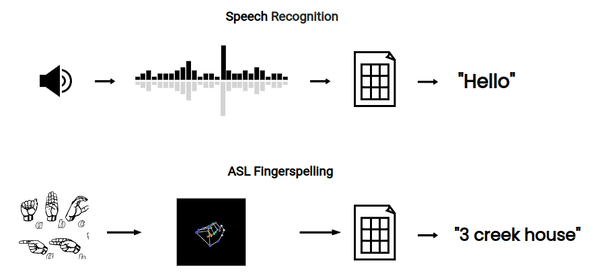

## 4.1 Define the Transformer Input Layers

When processing landmark coordinate features for the encoder, we apply convolutional layers to downsample them and process local relationships. 

We sum position embeddings and token embeddings when processing past target tokens for the decoder.

In [ ]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

## 4.2 Encoder layer for Transformer

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## 4.3 Decoder layer for Transformer

In [ ]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

## 4.4 Complete the Transformer model

This model takes landmark coordinates as inputs and predicts a sequence of characters. The target character sequence, which has been shifted to the left is provided as the input to the decoder during training. The decoder employs its own past predictions during inference to forecast the next token.

The **Levenshtein Distance** between sequences is used as the accuracy metric since the evaluation metric for this contest is the **Normalized Total Levenshtein Distance**.

In [ ]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

The following callback function is used to display predictions.

In [ ]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

# 5\. Train the Transformer model

In [ ]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=13)

# Plot training loss and validation loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

# Submission

Refrence: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

# Create TFLite model

In [ ]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [ ]:
model.save_weights("model.h5")

In [ ]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [ ]:
!zip submission.zip  './model.tflite' './inference_args.json'

In [ ]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)